# Checkbox Classifier Using PyTorch

In this notebook we're going to create a neural network capable of classifying an image of a checkbox, telling us whether it's checked, unchecked or not a checkbox at all

To do that we have a dataset of ~500 checkbox images varying in size, form and color. Let's begin!

## Environment

In case you're creating your own environment, install the dependencies

In [1]:
# !pip install -r requirements.txt

## Dataset

In the first section we will create our dataset class using the images we have

In [2]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image, ImageOps
from torchvision import transforms

torch.manual_seed(42)

class CheckboxesDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.classes = ['checked', 'unchecked', 'other']
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.samples = self._load_samples()

    def _load_samples(self):
        samples = []
        for label in self.classes:
            # Assuming you have 'checked', 'unchecked' and 'other' subfolders in your data dir
            label_dir = os.path.join(self.data_dir, label)
            for img_name in os.listdir(label_dir):
                if img_name.lower().endswith('.png'):
                    img_path = os.path.join(label_dir, img_name)
                    samples.append((img_path, self.class_to_idx[label]))
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.item()

        img_path, label = self.samples[idx]
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        return image, label

## Transforms

Here we are going to compose transforms for our dataset. Some of them are going to clear the data and some are going to augment our data during the training.

### Color

We should leave the image to be colored and not convert it to grayscale so we don't accidentally lose some patterns related to color

### Custom Padding

This transform will find the most common edge color (which is the background color in most cases) and add some padding in that color

### Largest Contour

The main custom transform we're going to implement is finding the largest contour in the image.

It works because in most of the cases the larges contour is actually the checkbox (sometimes it zooms in on some random elements of the image but it happens in just a few cases and does not affect the overall improvement).

After some testing I found that the best results are reached with some Gaussian blur.

### Augmentation

We augment the images by altering color and position of the switch on the image (turning or flipping the image could affect the ability to correctly classify the image, so we shouldn't use that)

### Size

Since the checkbox itself is not that complex object, then we don't need a high resolution

In [3]:
import cv2
from collections import Counter


class CustomPad:
    def __init__(self, padding, random_padding=False):
        self.padding = padding
        self.random_padding = random_padding

    def _find_border_color(self, image):
        pixels = list(image.getdata())
        width, height = image.size
        # Get pixels from the image edges
        edge_pixels = pixels[:width] + pixels[-width:] + [pixels[n*width] for n in range(height)] + [pixels[n*width-1] for n in range(1,height+1)]
        most_common_color = Counter(edge_pixels).most_common(1)[0][0]

        return most_common_color

    def __call__(self, img):
        if self.random_padding:
            # Generate random padding sizes for each side
            rand = lambda p: torch.randint(0, p + 1, (1,)).item()
            left = rand(self.padding)
            top = rand(self.padding)
            right = rand(self.padding)
            bottom = rand(self.padding)
        else:
            left = top = right = bottom = self.padding

        border_color = self._find_border_color(img)
        new_img = ImageOps.expand(img, border=(left, top, right, bottom), fill=border_color)
        return new_img


class LargestContourCrop:
    def __init__(self, padding=10, sigma=0.5):
        self.padding = padding
        self.sigma = sigma

    def __call__(self, image):
        image_np = np.array(image)

        gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)

        # Apply Gaussian blur with a small sigma for less blurring
        blurred = cv2.GaussianBlur(gray, (0, 0), self.sigma)

        edges = cv2.Canny(blurred, threshold1=30, threshold2=100)

        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if contours:
            largest_contour = max(contours, key=cv2.contourArea)

            x, y, w, h = cv2.boundingRect(largest_contour)

            # Add padding to the bounding box
            x_pad = max(x - self.padding, 0)
            y_pad = max(y - self.padding, 0)
            w_pad = min(w + 2 * self.padding, image_np.shape[1] - x_pad)
            h_pad = min(h + 2 * self.padding, image_np.shape[0] - y_pad)

            cropped_image = image_np[y_pad:y_pad+h_pad, x_pad:x_pad+w_pad]

            return Image.fromarray(cropped_image)

        return image


transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert('RGB')), # Convert image to RGB, discarding the alpha channel if present
    CustomPad(padding=20),
    LargestContourCrop(padding=10, sigma=0.5),
    CustomPad(padding=20, random_padding=True),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomResizedCrop(size=(64, 64), scale=(0.8, 1.0)),
    transforms.ToTensor(),
])

transform_no_custom_transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert('RGB')),
    transforms.ToTensor(),
])

## Data Loaders

We need to divide our data into train, validation and test subsets. Having this small amount of data, let's use 80% for training, 10% for validation and 10% for testing.

For the same reason we should also implement stratification to have a proportional amount of each class in each data subset

In [4]:
from torch.utils.data import Subset
import numpy as np

# Assuming your data dir called 'data'
data_dir = 'data'
checkboxes_dataset = CheckboxesDataset(data_dir=data_dir, transform=transform)
# Creating a no-transfrom dataset to see the change after transformation
checkboxes_dataset_no_custom_transform = CheckboxesDataset(data_dir=data_dir, transform=transform_no_custom_transform)


def stratified_split(dataset, train_ratio, validation_ratio, test_ratio):
    assert train_ratio + validation_ratio + test_ratio == 1

    # Get the list of indices for each class
    class_indices = {class_idx: [] for class_idx in range(len(dataset.classes))}
    for idx, (_, class_idx) in enumerate(dataset.samples):
        class_indices[class_idx].append(idx)

    # Split indices for each class
    train_indices, validation_indices, test_indices = [], [], []
    for indices in class_indices.values():
        indices = [indices[i] for i in torch.randperm(len(indices))]
        train_end = int(len(indices) * train_ratio)
        valid_end = train_end + int(len(indices) * validation_ratio)

        train_indices.extend(indices[:train_end])
        validation_indices.extend(indices[train_end:valid_end])
        test_indices.extend(indices[valid_end:])

    return Subset(dataset, train_indices), Subset(dataset, validation_indices), Subset(dataset, test_indices)


train_dataset, validation_dataset, test_dataset = stratified_split(checkboxes_dataset, train_ratio=0.8, validation_ratio=0.1, test_ratio=0.1)

# Create DataLoaders for each set
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=4)
test_loader = DataLoader(test_dataset, batch_size=4)

## Display transformation

Let's look at our transform result by taking 4 random images from the no-transforms dataset and from the transformed one

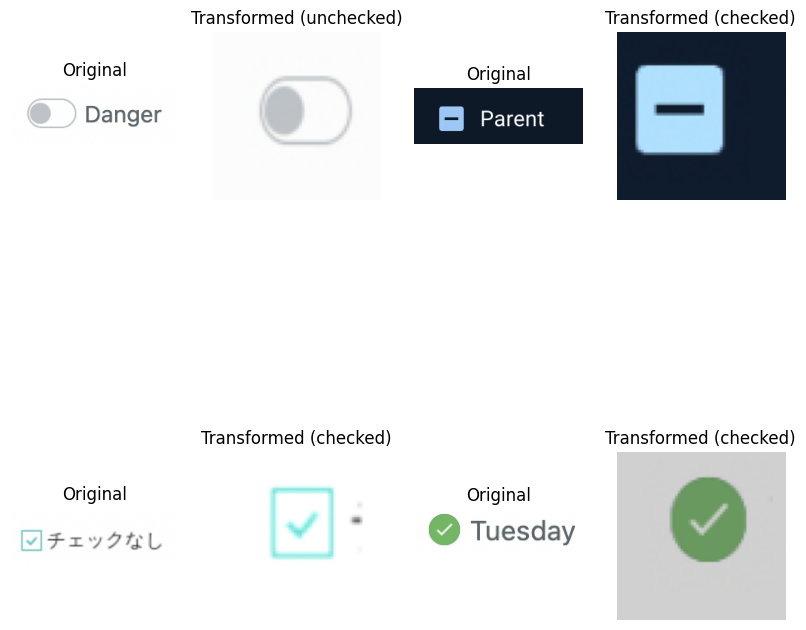

In [5]:
import matplotlib.pyplot as plt

def imshow(img):
    if img.shape[0] == 3:
        img = img.numpy().transpose((1, 2, 0))
    else:
        img = img.numpy()[0]
    plt.imshow(img)
    plt.axis('off')

def show_random_images(dataset, dataset_no_custom_transform, num_images=4):
    fig = plt.figure(figsize=(10, 10))

    for i in range(num_images):
        idx = np.random.randint(0, len(dataset))
        transformed_img, label = dataset[idx]
        original_img, _ = dataset_no_custom_transform[idx]

        while dataset.classes[label] == "other":
            idx = np.random.randint(0, len(dataset))
            transformed_img, label = dataset[idx]
            original_img, _ = dataset_no_custom_transform[idx]

        ax = fig.add_subplot(2, num_images, 2*i+1, xticks=[], yticks=[])
        imshow(original_img)
        ax.set_title("Original")

        ax = fig.add_subplot(2, num_images, 2*i+2, xticks=[], yticks=[])
        imshow(transformed_img)
        ax.set_title(f"Transformed ({dataset.classes[label]})")

show_random_images(checkboxes_dataset, checkboxes_dataset_no_custom_transform)

## Choosing the model

As for the model choise let's use a ConvNet as our model as it's the most common model used for image classification.

The images we use are small and minimalistic with not a lot of details so it's fine to use a simple structure. I decided to go with two convolution layers with pooling and two fully connected layers with a dropout

In [6]:
from torch import nn

class CheckboxClassifier(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(nn.ReLU()(self.conv1(x)))
        x = self.pool(nn.ReLU()(self.conv2(x)))
        x = nn.Flatten()(x)
        x = nn.ReLU()(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# TODO: Make GPU work on Docker
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CheckboxClassifier().to(device)
device

device(type='cpu')

## Real time validation/loss plotting

Let's implement real time val/loss plotting to easily observe the training process

In [7]:
from IPython.display import clear_output

def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

def live_plot(loss_vals, val_loss_vals, acc_vals, val_acc_vals, figsize=(15,5), title=''):
    clear_output(wait=True)

    # Apply smoothing to the loss and accuracy values
    plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    plt.plot(smooth_curve(loss_vals), label='Train Loss')
    plt.plot(smooth_curve(val_loss_vals), label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(smooth_curve(acc_vals), label='Train Acc')
    plt.plot(smooth_curve(val_acc_vals), label='Val Acc')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.suptitle(title)
    plt.show()

## Training Loop

Here we're going to implement our training loop

### Criterion

Cross entropy loss is the most common loss criterion for multiclass classificaiton

### Optimizer

After some testing I found that Adam optimizer would work best for our model. I also added some L2 regularization in addition to the dropout layer to avoid overfitting

### Epochs

100 epochs would be enough for our model to converge

In [8]:
from torch import optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25):
    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    for epoch in range(num_epochs):
        model.train()

        running_loss, running_corrects = 0.0, 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        # Update train_losses and train_accs for plotting
        train_losses.append(running_loss / len(train_loader.dataset))
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        train_accs.append(epoch_acc.cpu().item())

        model.eval()

        val_running_loss, val_running_corrects = 0.0, 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += torch.sum(preds == labels.data)

        # Update val_losses and val_accs for plotting
        val_losses.append(val_running_loss / len(val_loader.dataset))
        val_epoch_acc = val_running_corrects.double() / len(val_loader.dataset)
        val_accs.append(val_epoch_acc.cpu().item())

        # Plotting
        live_plot(train_losses, val_losses, train_accs, val_accs, title=f'Epoch: {epoch+1}/{num_epochs}')

    print('Training complete')
    return model

## Run the training

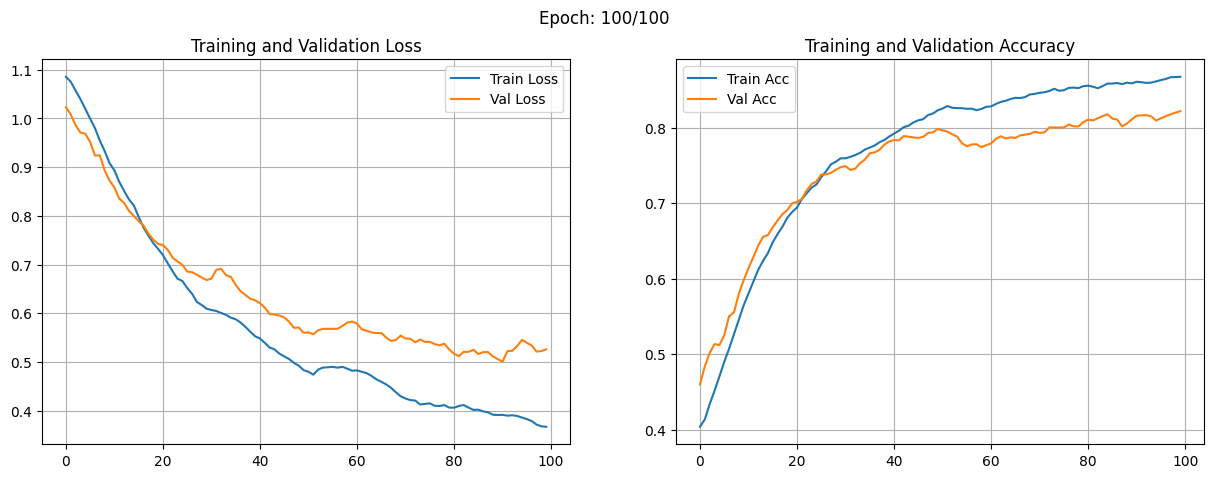

Training complete


In [9]:
trained_model = train_model(model, train_loader, validation_loader, criterion, optimizer, num_epochs=100)

## Analysis

It looks like our model's validation loss starts increasing after some point. That could be a sign of overfitting.

But because the accuracy still doesn't go down (even though the growth is slower than for training accuracy) we might assume that we have some outliers affecting our validation picture. Let's look at loss distribution on individual samples.

In [10]:
import matplotlib.pyplot as plt
import torch

def plot_loss_distribution(model, data_loader, criterion, device='cpu'):
    model.eval()
    sample_losses = []

    classes = data_loader.dataset.dataset.classes

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Calculate loss for each sample in the batch
            for i in range(inputs.size(0)):
                individual_loss = criterion(outputs[i].unsqueeze(0), labels[i].unsqueeze(0)).item()

                image = inputs[i].cpu().numpy()
                label = labels[i].cpu().numpy()
                pred = preds[i].item()
                sample_losses.append((individual_loss, image, classes[label], classes[pred]))

    plt.figure(figsize=(8, 4))
    plt.hist([loss for loss, _, _, _ in sample_losses], bins=50, alpha=0.75)
    plt.title('Distribution of Losses on Individual Samples')
    plt.xlabel('Loss')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    return sample_losses


def show_highest_loss_images(sample_losses, num_images=4):
    # Select the images with the highest loss
    highest_losses = sorted(sample_losses, key=lambda x: x[0], reverse=True)[:num_images]

    plt.figure(figsize=(6, 6))

    for i, (loss, image, label, pred) in enumerate(highest_losses, 1):
        ax = plt.subplot(2, 2, i)
        ax.axis('off')
        ax.set_title(f'Loss: {loss:.4f}\nTrue: {label} Pred: {pred}')
        plt.imshow(image.transpose((1, 2, 0)))

    plt.show()


### Validation set loss distribution

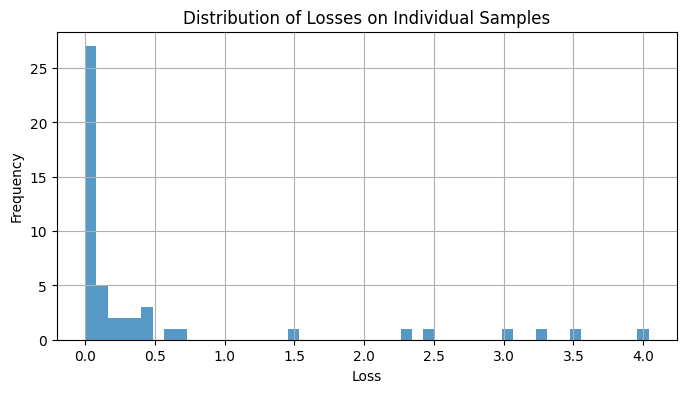

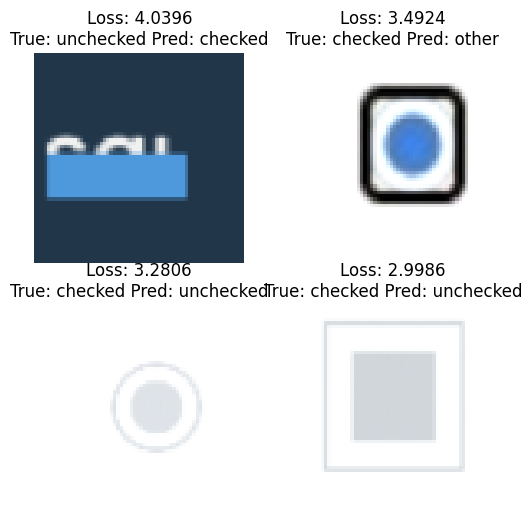

In [19]:
val_sample_losses = plot_loss_distribution(model, validation_loader, criterion, device)
show_highest_loss_images(val_sample_losses)

In most cases we can see that some of those images are obvious outliers (they could appear because of the failed contour detection or because the original image itself is ambiguous). These outliers affect the mean loss value, but the mode value of loss is actually low

## Testing the model

This script will pass the testing dataset through the model and show the final accuracy. It will also display the first four images

Test Loss: 0.4954, Test Accuracy: 0.8148
First four images:


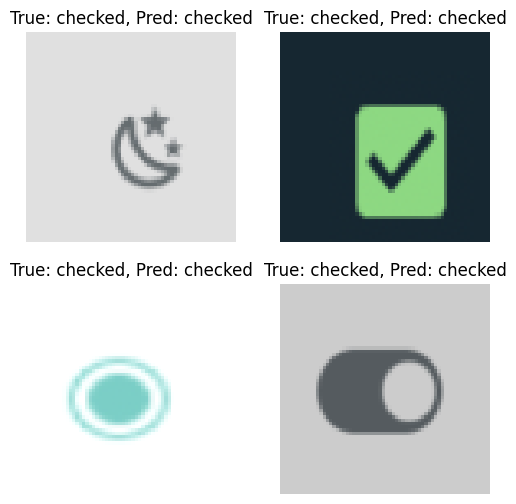

In [12]:
import matplotlib.pyplot as plt
import torch

def evaluate_model(model, test_loader, criterion, device='cpu'):
    model.eval()

    running_loss, running_corrects, total = 0.0, 0, 0
    num_images_to_show, images_shown = 4, 0

    fig = plt.figure(figsize=(6, 6))

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total += labels.size(0)

            if images_shown < num_images_to_show:
                for i in range(inputs.size(0)):
                    if images_shown >= num_images_to_show:
                        break
                    img = inputs[i].cpu().numpy().transpose((1, 2, 0))
                    label = labels[i].item()
                    pred = preds[i].item()

                    images_shown += 1

                    ax = plt.subplot(2, 2, images_shown)
                    ax.axis("off")
                    classes = test_loader.dataset.dataset.classes
                    ax.set_title(f'True: {classes[label]}, Pred: {classes[pred]}')
                    plt.imshow(img)

    final_loss = running_loss / total
    final_accuracy = running_corrects.double() / total

    print(f'Test Loss: {final_loss:.4f}, Test Accuracy: {final_accuracy:.4f}')
    print("First four images:")

evaluate_model(model, test_loader, criterion, device)

### Test set loss distribution

Let's also check a loss distribution on individual samples and look at the worst cases as we did previously.

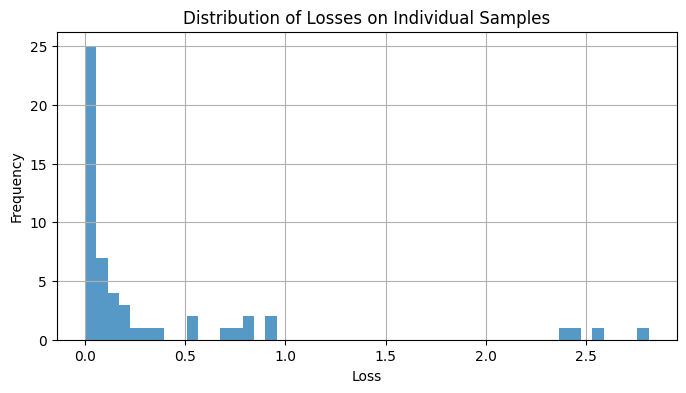

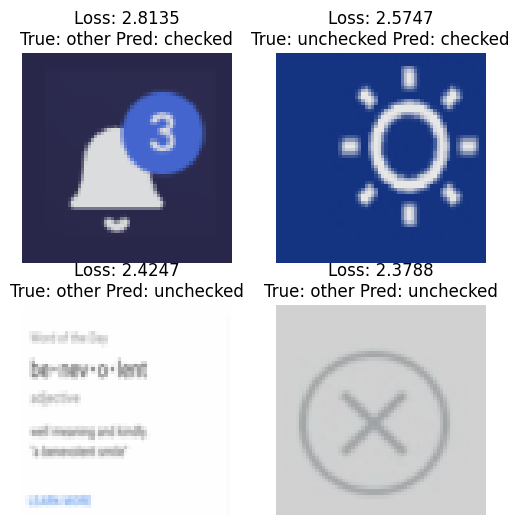

In [21]:
test_sample_losses = plot_loss_distribution(model, test_loader, criterion, device)
show_highest_loss_images(test_sample_losses)

Looks like the result is the same as we got for validation dataset, there are some outliers, the mode value of loss is low.

This could be leveled out with a better data preprocessing and just a better raw data

## Save the model parameters

You can do that here

In [14]:
# torch.save(model.state_dict(), 'checkbox_nn_parameters.pth')

## Results and ways of improvement

After a several runs the current configuration gave me around **80% accuracy** on a test set (could be lower or higher, depends on how the dataset gets distributed), which is not a bad result considering the fact that some of the images are difficult to classify even for a human

What could be done to improve the result:
- **Dataset improvement**: manually check the dataset for outliers or add some more good samples, this way the model would converge a lot better
- **Data preprocessing**: the largest contour transform is good but far from being perfect, sometimes it causes some samples to be totally incorrect. It would be nice to find some more reliable way of cleaning the data (detecting based on color difference, using another neural network, etc.)
- **Model design**: some experimenting with model desing could help. But we could also try to use transfer learning with some existing model like VGG or ResNet
- **Hyperparameters tuning**: parameters like learning rate, num of epochs, regularization rate or even model's parameters like layers and neurons could be automatically fine-tuned with some library like Ray Tune
- **Inspect data**: experimenting on the train set, removing and adding specific samples, understanding what kind of images works best for training could give you and idea of which patterns the model learns easily and on which ones it struggles